In [30]:
#!/usr/bin/env python3
import numpy as np, matplotlib.pyplot as plt
from qiskit_nature.second_q.operators.tensor_ordering import to_chemist_ordering
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.circuit.library.initial_states import HartreeFock
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B

In [31]:
# Load MO-space integrals (from PySCF)
hdat = np.load("../data/h2_sto3g_R0p74.npz")
h1_mo  = hdat["h1"]                
eri_mo = hdat["eri"]               

eri_chem_guess = to_chemist_ordering(eri_mo)
if np.max(np.abs(eri_chem_guess - eri_mo)) > 1e-12:
    eri_mo = eri_chem_guess 

# Load TN rotation (U_no) and rotate to NO basis
tdat = np.load("../data/h2_no_from_dmrg.npz")
U_no  = tdat["U_no"]               # (2,2)
E_dmrg = float(tdat["E_dmrg"])

h1 = U_no.T @ h1_mo @ U_no
eri = np.einsum("pa,qb,rc,sd,abcd->pqrs", U_no, U_no, U_no, U_no, eri_mo, optimize=True)

# Build qubit Hamiltonian (Jordan–Wigner)
ham = ElectronicEnergy.from_raw_integrals(h1, eri)  
problem = ElectronicStructureProblem(ham)
mapper  = JordanWignerMapper()
Hq = mapper.map(problem.hamiltonian.second_q_op())

# UCCSD ansatz for H2 (2 spatial orbitals, 2 electrons)
nelec = (1, 1)
norb = 2
init_hf = HartreeFock(norb, nelec, mapper)
ansatz  = UCCSD(num_spatial_orbitals=norb, num_particles=nelec,
                qubit_mapper=mapper, initial_state=init_hf)
ansatz.decompose().draw("mpl", style={"name": "iqx"}); plt.show()

/home/david/repos/tensor-networks/.venv/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /home/david/repos/tensor-networks/.venv/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In [32]:
E_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(Hq).eigenvalue.real
print("Exact (NumPy solver) =", E_exact, "   DMRG(TN) =", E_dmrg)

Exact (NumPy solver) = -1.8523881735695784    DMRG(TN) = -1.8523881735695833


In [33]:
est = AerEstimator(backend_options={"method":"statevector"}, run_options={"shots":1024})
npar = ansatz.num_parameters
print("UCCSD num_parameters =", npar)
params = list(ansatz.parameters)  

# line-search along a simple direction (all-ones) to get a good initial point
thetas = np.linspace(-2.0, 2.0, 161)
direction = np.ones(npar) 
ener_scan = []
for th in thetas:
    pv = (th * direction).tolist()            
    e = est.run([ansatz], [Hq], [pv]).result().values[0].real
    ener_scan.append(e)

theta0 = float(thetas[int(np.argmin(ener_scan))])
pv0 = (theta0 * direction).tolist()
print("Line-search θ0 =", theta0, "  E(θ0) =", min(ener_scan))

fine = np.linspace(theta0-0.3, theta0+0.3, 121)
ener_fine = []
for th in fine:
    pv = (th * direction).tolist()
    e = est.run([ansatz], [Hq], [pv]).result().values[0].real
    ener_fine.append(e)
theta0 = float(fine[int(np.argmin(ener_fine))])
pv0 = (theta0 * direction).tolist()
print("Refined θ0 =", theta0, "  E(θ0) =", min(ener_fine))

evals, energies = [], []
def cb(k, x, mean, std):
    evals.append(k); energies.append(mean)

opt = L_BFGS_B(maxiter=80)  
vqe = VQE(est, ansatz, opt, initial_point=pv0, callback=cb)
res = vqe.compute_minimum_eigenvalue(Hq)
print("VQE(UCCSD) =", res.optimal_value)


UCCSD num_parameters = 3
Line-search θ0 = -0.04999999999999982   E(θ0) = -1.8448437955365309
Refined θ0 = -0.039999999999999813   E(θ0) = -1.8483327530908187
VQE(UCCSD) = -1.8426285642735962


Final energies:
  NO : -1.835296722481397
  CAN: -1.8383846335604033
  Exact: -1.8523881735695784   DMRG: -1.8523881735695833
Saved h2_vqe_convergence_AB.png
Saved h2_vqe_error_log.png


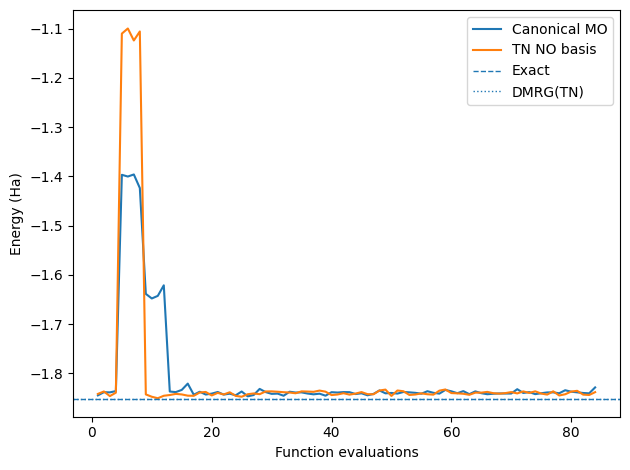

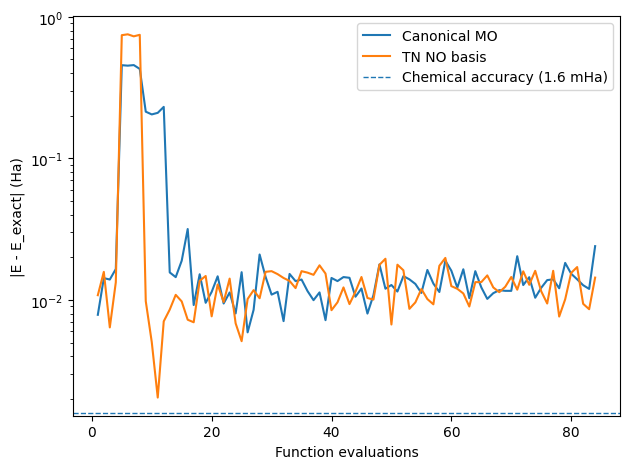

In [34]:
# build canonical MO baseline Hamiltonian
h1_mo = hdat["h1"]
eri_chem = to_chemist_ordering(hdat["eri"])
ham_can = ElectronicEnergy.from_raw_integrals(h1_mo, eri_chem)
prob_can = ElectronicStructureProblem(ham_can)
mapper = JordanWignerMapper()
Hq_can = mapper.map(prob_can.hamiltonian.second_q_op())

# Run VQE on TN-NO and canonical
def run_vqe(Hq, ansatz, seed_params, label):
    evals, energies = [], []
    def cb(k, x, mean, std):
        evals.append(k); energies.append(mean)
    opt = L_BFGS_B(maxiter=80)
    vqe = VQE(est, ansatz, opt, initial_point=seed_params, callback=cb)
    res = vqe.compute_minimum_eigenvalue(Hq)
    return {"label":label, "evals":np.array(evals), "ener":np.array(energies), "res":res}

run_no  = run_vqe(Hq,     ansatz, pv0,        "TN NO basis")
run_can = run_vqe(Hq_can, ansatz, pv0,        "Canonical MO")

print("Final energies:")
print("  NO :", run_no["res"].optimal_value)
print("  CAN:", run_can["res"].optimal_value)
print("  Exact:", E_exact, "  DMRG:", E_dmrg)

# convergence energy vs evaluations
plt.figure()
for r in [run_can, run_no]:
    x = r["evals"] if len(r["evals"]) else np.arange(len(r["ener"]))
    plt.plot(x, r["ener"], label=r["label"])
plt.axhline(E_exact, ls="--", lw=1, label="Exact")
plt.axhline(E_dmrg,  ls=":",  lw=1, label="DMRG(TN)")
plt.xlabel("Function evaluations")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.tight_layout()
plt.savefig("h2_vqe_convergence_AB.png", dpi=200)
print("Saved h2_vqe_convergence_AB.png")

# error vs exact
plt.figure()
for r in [run_can, run_no]:
    x = r["evals"] if len(r["evals"]) else np.arange(len(r["ener"]))
    err = np.abs(r["ener"] - E_exact)
    plt.semilogy(x, err, label=r["label"])
plt.axhline(0.0016, ls="--", lw=1, label="Chemical accuracy (1.6 mHa)")
plt.xlabel("Function evaluations")
plt.ylabel("|E - E_exact| (Ha)")
plt.legend()
plt.tight_layout()
plt.savefig("h2_vqe_error_log.png", dpi=200)
print("Saved h2_vqe_error_log.png")
